In [1]:
# Spark imports
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, pandas_udf, col, PandasUDFType, lit, round, array_contains
from pyspark.sql.functions import monotonically_increasing_id, row_number, col
from pyspark.sql.types import DoubleType, StructType, StructField
from pyspark.sql.functions import when, split, col, concat_ws
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Regular imports
from IPython.display import display, HTML
import os, time
import subprocess
import os,shutil
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import h3pandas
import h3

# Settings
project = "project_opdi"

# Getting today's date
today = datetime.today().strftime('%d %B %Y')

# Setting logging properties
#shutil.copy("/runtime-addons/cmladdon-2.0.40-b154/log4j.properties", "/etc/spark/conf/") 

# Spark Session Initialization
spark = SparkSession.builder \
    .appName("OSN ADEP ADES Identification") \
    .config("spark.log.level", "ERROR")\
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-opdi") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/opdi.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "8G") \
    .config("spark.executor.memory", "2G") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "400s") \
    .config("spark.driver.maxResultSize", "4g") \
    .enableHiveSupport() \
    .getOrCreate()

# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


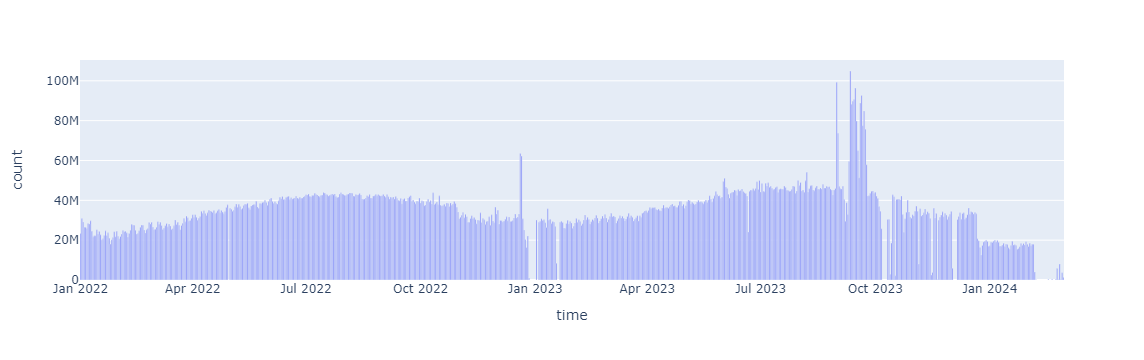

In [3]:
df = spark.sql("""
SELECT TO_DATE(from_unixtime(event_time)), COUNT(*) 
FROM `project_opdi`.`osn_tracks_clustered`
GROUP BY TO_DATE(from_unixtime(event_time));""").toPandas()

df.to_parquet('counts_per_day_osn_tracks.parquet')

df.columns = ['time', 'count']

import plotly.express as px
date_col = 'time'
count_col = 'count'
fig = px.bar(df, x=date_col, y=count_col)
fig

In [2]:
df = spark.sql("""
SELECT TO_DATE(from_unixtime(event_time)), COUNT(*) 
FROM `project_opdi`.`osn_statevectors`
GROUP BY TO_DATE(from_unixtime(event_time));""").toPandas()

df.to_parquet('counts_per_day_osn_statevectors.parquet')

df.columns = ['time', 'count']

import plotly.express as px
date_col = 'time'
count_col = 'count'
fig = px.bar(df, x=date_col, y=count_col)
fig

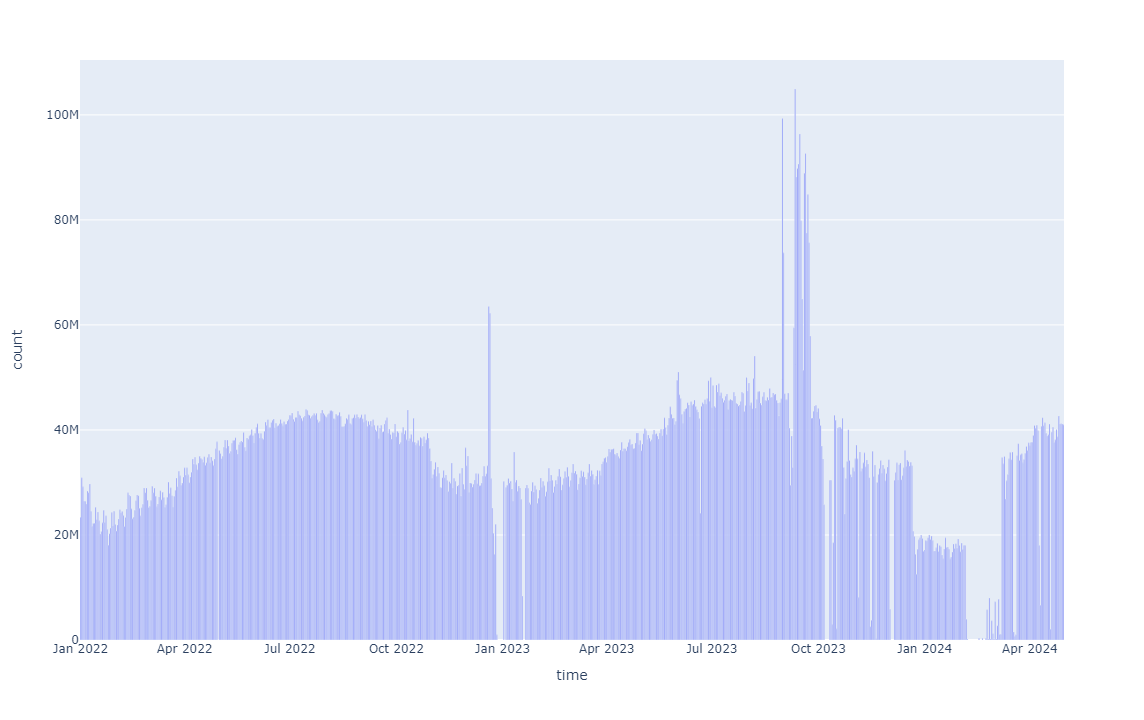

In [5]:
df = spark.sql("""
SELECT TO_DATE(from_unixtime(event_time)), COUNT(*) 
FROM `project_opdi`.`osn_statevectors_clustered`
GROUP BY TO_DATE(from_unixtime(event_time));""").toPandas()

df.to_parquet('counts_per_day_osn_statevectors_clustered.parquet')

df.columns = ['time', 'count']

import plotly.express as px
date_col = 'time'
count_col = 'count'
fig = px.bar(df, x=date_col, y=count_col)
fig

In [ ]:
df = spark.sql("""
SELECT TO_DATE(from_unixtime(event_time)), COUNT(*) 
FROM `project_opdi`.`osn_tracks_clustered`
GROUP BY TO_DATE(from_unixtime(event_time));""").toPandas()

df.to_parquet('counts_per_day_osn_tracks_clustered.parquet')

df.columns = ['time', 'count']

import plotly.express as px
date_col = 'time'
count_col = 'count'
fig = px.bar(df, x=date_col, y=count_col)
fig

In [ ]:
df = spark.sql("""
SELECT TO_DATE(from_unixtime(event_time)), COUNT(*) 
FROM `project_opdi`.`osn_statevectors`
GROUP BY TO_DATE(from_unixtime(event_time));""").toPandas()

df.to_parquet('counts_per_day_osn_statevectors.parquet')

Hive Session ID = c02dbdd1-0aa9-42f3-a41a-13913f193ac8


## Query testing sample function

In [2]:
def get_data_within_timeframe(spark, table_name, start_date, stop_date):
    """
    Retrieves records from a specified Spark table within the given timeframe.

    Args:
    spark (SparkSession): The SparkSession object.
    table_name (str): The name of the Spark table to query.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    stop_date (str): The stop date in 'YYYY-MM-DD' format.

    Returns:
    pyspark.sql.dataframe.DataFrame: A DataFrame containing the records within the specified timeframe.
    """
    # Convert dates to POSIX time (seconds since epoch)
    start_posix = int(time.mktime(time.strptime(start_date, '%Y-%m-%d')))
    stop_posix = int(time.mktime(time.strptime(stop_date, '%Y-%m-%d')))

    # Load the table
    df = spark.table(table_name)

    # Filter records based on event_time column
    filtered_df = df.filter((col('event_time') >= start_posix) & (col('event_time') < stop_posix))

    return filtered_df

#sdf.write.format('parquet').save("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

#sdf = spark.read.format('parquet').load("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

## Create airport runway hexagonification spark dataset 

#### Reasoning

For an incoming aircraft, landing in the center of this cylinder would be at an angle of 3 degrees. Assuming we want to see - at least - the flight coming down from FL10 to see the landing, we need thus to have a minimal distance tan(3) = 3048/? => ? = 3048/tan(3) = 58159 meter = 31,403348 nautical miles. 

We'll thus look into concentric circles 30NM around the airport and a max flight level FL20 (which covers higher incoming angles up to 6degrees). 

#### To do:
   * Upload airport_concentric_c_hex_res_6.arrow dataset to datalake.

In [3]:
df_apt = pd.read_parquet('../../data/airport_hex/airport_concentric_c_hex_res_6.arrow')

# Filter out relevant hexagons
df_apt = df_apt[df_apt.max_c_radius_nm<=30]
df_apt = df_apt[['ident','hex_id']].explode('hex_id')
df_apt = df_apt[~df_apt.hex_id.isna()]

# Getting h3 positions of hexagons 
df_apt['geo'] = df_apt['hex_id'].apply(lambda l:h3.h3_to_geo(l))
df_apt['lat'] = df_apt['geo'].apply(lambda l:l[0])
df_apt['lon'] = df_apt['geo'].apply(lambda l:l[1])
df_apt = df_apt.drop('geo',axis=1)

# OSN bounding box filter
f_lat = np.logical_and(df_apt.lat >=26.74617, df_apt.lat <= 70.25976)  
f_lon = np.logical_and(df_apt.lon >=-25.86653, df_apt.lon <= 49.65699)  
f = np.logical_and(f_lat, f_lon)
df_apt = df_apt[f]

# Renaming columns 
df_apt.columns = ['apt_' + x for x in df_apt.columns]

# Grouping by hex id
df_apt = df_apt.groupby('apt_hex_id').agg(list)['apt_ident'].reset_index()

# Creating spark df
sdf_apt = spark.createDataFrame(df_apt)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


### Clean statevector data & filter out low altitude (<FL20)

In [4]:
# Query data from datalake sample 
max_FL = 20

sv = get_data_within_timeframe( # State Vectors sv
    spark = spark, 
    table_name = 'project_opdi.osn_tracks_clustered', 
    start_date = '2023-06-03', 
    stop_date = '2023-06-05')

# Filter out rows with missing crucial data
sv_f = sv.dropna(subset=['lat', 'lon', 'baro_altitude', 'track_id'])

# Add statevector id (commented out because expensive)
#sv_f = add_sv_id(sv_f)

# Rename callsign to flight_id (official term)
sv_f = sv_f.withColumnRenamed("callsign", "flight_id")

# Replace missing 'flight_id' with empty string
sv_f = sv_f.fillna({'flight_id': ''})

# Convert event_time from posixtime to datetime 
sv_f = sv_f.withColumn('event_time', F.to_timestamp(F.col('event_time')))

# Add flight level extracted from baro_altitude
sv_f = sv_f.withColumn('flight_level', (col('baro_altitude') * 3.28084 / 100).cast('int'))

# Select columns of interest
columns_of_interest = [
    'track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',  'flight_level',
    'heading', 'vert_rate',  'on_ground', 'h3_res_6', 'h3_res_11'
]
sv_f = sv_f.select(columns_of_interest)

# Filter out low altitude statevectors during landing/take-off (below FL20)
sv_low_alt = sv_f.filter(col('flight_level') <= max_FL).cache()

Hive Session ID = 6493975b-3133-4746-aea6-1799b4bb71f6


In [5]:
# Merge airports hexaero grid (sdf_apt) onto statevectors to see which tracks are within 30 NM (+-h3 res 6 inaccuracy). 
sv_nearby_apt = sv_low_alt.join(sdf_apt, (sv_low_alt.h3_res_6 == sdf_apt.apt_hex_id), "left")

In [ ]:
df_test = sv_f.toPandas()

In [ ]:
df_test